# Explore here

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import random

2024-01-03 19:03:50.605863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 19:03:50.605936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 19:03:50.608543: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 19:03:50.621781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 19:03:51.647917: W tensorflow/compiler/tf2

In [2]:
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)

data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 2s 0us/step


In [3]:
img_size = (160, 160)
batch_size = 32

train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


Found 3000 files belonging to 2 classes.
Using 600 files for validation.


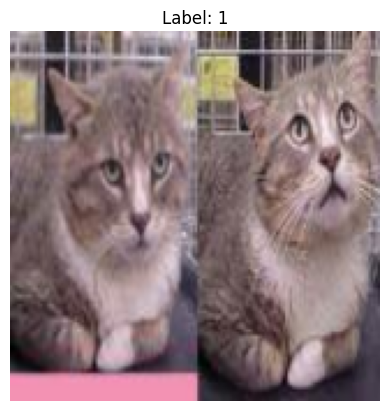

In [4]:
images, labels = next(iter(validation_dataset))


image = images[0] 
label = labels[0]  

label_str = str(label.numpy())

plt.figure()
plt.imshow(image.numpy().astype("uint8"))  
plt.title(f"Label: {label_str}") 
plt.axis("off") 
plt.show()

In [5]:
image.numpy().shape

(160, 160, 3)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False, # No incluimos la capa de salida
                                               weights='imagenet')


pretrained_model.trainable = False

model = models.Sequential([
  pretrained_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [8]:
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset)

Epoch 1/5
75/75 [==============================] - 30s 359ms/step - loss: 0.7214 - accuracy: 0.6083 - val_loss: 0.6831 - val_accuracy: 0.6433
Epoch 2/5
75/75 [==============================] - 31s 415ms/step - loss: 0.6612 - accuracy: 0.6383 - val_loss: 0.6764 - val_accuracy: 0.6233
Epoch 3/5
75/75 [==============================] - 26s 344ms/step - loss: 0.6468 - accuracy: 0.6475 - val_loss: 0.6848 - val_accuracy: 0.6550
Epoch 4/5
75/75 [==============================] - 26s 343ms/step - loss: 0.6355 - accuracy: 0.6587 - val_loss: 0.6726 - val_accuracy: 0.6350
Epoch 5/5
75/75 [==============================] - 27s 355ms/step - loss: 0.6326 - accuracy: 0.6625 - val_loss: 0.6852 - val_accuracy: 0.6533


In [9]:
selected_images = validation_dataset.unbatch().batch(10).take(1)
sample_images = next(iter(selected_images))[0].numpy() / 255.0

predictions = model.predict(sample_images)

1/1 [==============================] - 1s 728ms/step


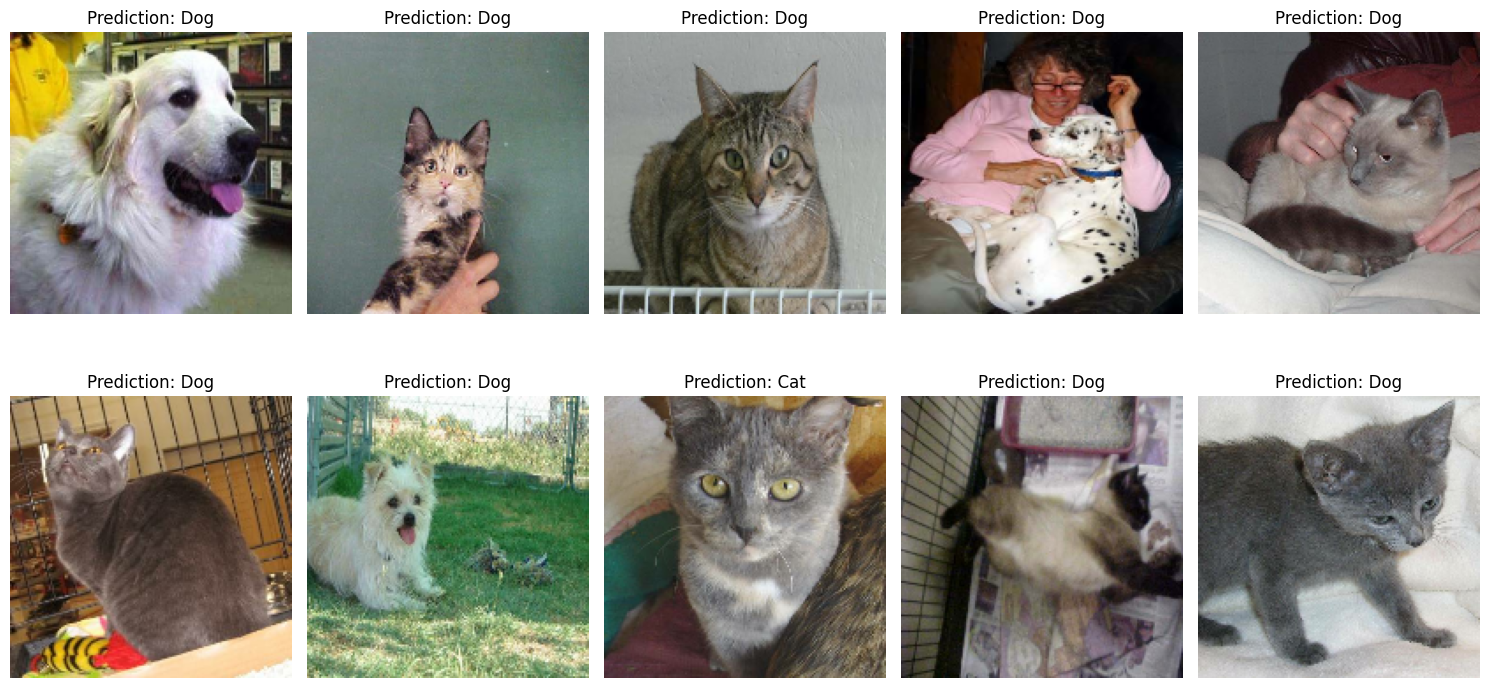

In [10]:
predicted_labels = ["Cat" if prediction >= 0.5 else "Dog" for prediction in predictions]

plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((sample_images[i]))
    plt.title(f"Prediction: {predicted_labels[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()